In [94]:
#!pip install pandas matplotlib scikit-learn torch torchvision
# if you get issues with importing torch, install it using conda using the following command
# conda install pytorch torchvision -c pytorch

In [95]:
#!pip install scikit-learn

In [96]:
import gzip
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time as time_module

In [97]:
def load_dataframe_from_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None

def load_dataframe_from_gz(gz_file_path):
    # Decompress the .gz file and read its content
    with gzip.open(gz_file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

def filter_stock_data(data_frame, stock_tickers):
    filtered_data = data_frame[data_frame['SYMBOL'].isin(stock_tickers)]
    return filtered_data

def calculate_price_and_indicators(df1, indicators):
    df = df1.copy()
    
    bid_column, ask_column, sell_columns, buy_columns = 'BID_PRICE_1', 'ASK_PRICE_1', ['ASK_SIZE_1', 'ASK_SIZE_2', 'ASK_SIZE_3'], ['BID_SIZE_1', 'BID_SIZE_2', 'BID_SIZE_3']
    
    # Calculate the price change for BID and ASK separately
    df['BidPriceChange'] = df[bid_column].pct_change()    
    df['AskPriceChange'] = df[ask_column].pct_change()
    df['Spread'] = df[ask_column] - df[bid_column]
    df['SpreadChange'] = df['Spread'].pct_change()

    df['BidPriceDir'] = (df['BidPriceChange'] > 0).astype(int)
    df['AskPriceDir'] = (df['AskPriceChange'] > 0).astype(int)
    # df['SpreadChange'] = (df['SpreadChange'] > 0).astype(int)

    if 'OFI' in indicators:
        # Calculate OFI and add it to the copy of the DataFrame
        total_buy_volume = df[buy_columns].sum(axis=1)
        total_sell_volume = df[sell_columns].sum(axis=1)
        df['OFI'] = (total_buy_volume - total_sell_volume) / (total_buy_volume + total_sell_volume)
        
    
    if 'MACD' in indicators:
        mid_price = (df[bid_column] + df[ask_column]) / 2
        EMA_12 = mid_price.ewm(span=12, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        EMA_26 = mid_price.ewm(span=26, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        df['MACD'] = EMA_12 - EMA_26
        df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    if 'RSI' in indicators:
        # Calculate RSI for past 20 rows
        delta = df['BidPriceChange'] - df['AskPriceChange']
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=20).mean()
        avg_loss = loss.rolling(window=20).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
    
    if 'EMA' in indicators:
        # Calculate EMA for past 20 rows
        df['EMA'] = df[bid_column].ewm(span=20, adjust=False).mean()

    # Filter the df with the data we need
    columns = ['COLLECTION_TIME', 'BID_PRICE_1', 'ASK_PRICE_1', 'BidPriceChange', 'AskPriceChange', 'SpreadChange', 'BidPriceDir', 'AskPriceDir'] + indicators
    df = df[columns]

    # Offset the price by 1 row so that the change is for the next row
    df['BidPriceChange'] = df['BidPriceChange'].shift(-1)
    df['AskPriceChange'] = df['AskPriceChange'].shift(-1)

    return df

def filter_time_window(df1, start_time, end_time):
    df = df1.copy()

    # Convert 'COLLECTION_TIME' column to datetime.time objects if it's not already
    if not isinstance(df['COLLECTION_TIME'].iloc[0], time):
        df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])

    # Create the mask to filter the time window
    mask = (df['COLLECTION_TIME'] >= start_time) & (df['COLLECTION_TIME'] < end_time)
    return df[mask]

def find_max_trading_hour(df):
    # Get a list of all unique time values
    unique_times = sorted(df['COLLECTION_TIME'].unique())

    max_trades = 0
    best_start_time = None
    best_end_time = None

    # Iterate over unique time values to consider each as a potential start time for the 1-hour window
    for time in unique_times:
        # Calculate the corresponding end time for a 1-hour window
        time_datetime = pd.to_datetime(str(time))
        end_time_datetime = time_datetime + pd.Timedelta(hours=1)
        
        # Use the filter_time_window function to get the data within this 1-hour window
        window_df = filter_time_window(df, time_datetime, end_time_datetime)

        # If this window has more trades than previous max, update the best times and max_trades value
        if window_df.shape[0] > max_trades:
            max_trades = window_df.shape[0]
            best_start_time = time
            best_end_time = end_time_datetime

    return best_start_time, best_end_time

def plot_histograms(df, columns):
    # Create subplots to display histograms for each column
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

    # Plot histograms for each column
    for i, column in enumerate(columns):
        ax = axes[i]
        ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_histograms_and_stats(df, columns):
    
    color_cycle = itertools.cycle(['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink', 'lightseagreen'])

    # Create subplots to display histograms for each column and statistics
    fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(12, 8))
    
    # Plot histograms for each column
    for i, column in enumerate(columns):
        ax_hist = axes[i, 0]
        ax_stats = axes[i, 1]

        # Get the next color from the color cycle
        color = next(color_cycle)

        # Plot histogram with the corresponding color
        ax_hist.hist(df[column], bins=30, color=color, edgecolor='black')
        ax_hist.set_title(f'Distribution of {column}')
        ax_hist.set_xlabel(column)
        ax_hist.set_ylabel('Frequency')

        # Calculate statistics
        num_zeros = (df[column] == 0).sum()
        num_positive = (df[column] > 0).sum()
        num_negative = (df[column] < 0).sum()

        # Display statistics
        stats_text = f"Zeros: {num_zeros}\nPositive: {num_positive}\nNegative: {num_negative}"
        ax_stats.text(0.5, 0.5, stats_text, fontsize=12, ha='center')
        ax_stats.axis('off')

    plt.tight_layout()
    plt.show()



In [98]:
# Example usage:
# deep_path = "book_snapshots/20211105_book_updates.csv"
deep_path = "sample_data/20211105_book_updates.csv.gz"
deep = load_dataframe_from_gz(deep_path)

# trades_path = "book_snapshots/20211105_trades.csv"
trades_path = "sample_data/20211105_trades.csv.gz"
trades = load_dataframe_from_gz(trades_path)

In [99]:
stock_tickers_list = ['AAPL'] # we can can add more
aapl = filter_stock_data(deep, stock_tickers_list)
aapl_trades = filter_stock_data(trades, stock_tickers_list)

In [100]:

indicators = ['OFI', 'RSI', 'MACD']
factors = calculate_price_and_indicators(aapl, indicators)

In [101]:
# factors

In [102]:

start, end = find_max_trading_hour(aapl_trades)
print(f"The 1-hour window with the highest trading activity is from {start} to {end}.")
filtered_factors = filter_time_window(factors, start, end)

The 1-hour window with the highest trading activity is from 2021-11-05 18:59:54.937584896 to 2021-11-05 19:59:54.937584896.


In [103]:
len(filtered_factors)

49356

In [104]:
49356/60

822.6

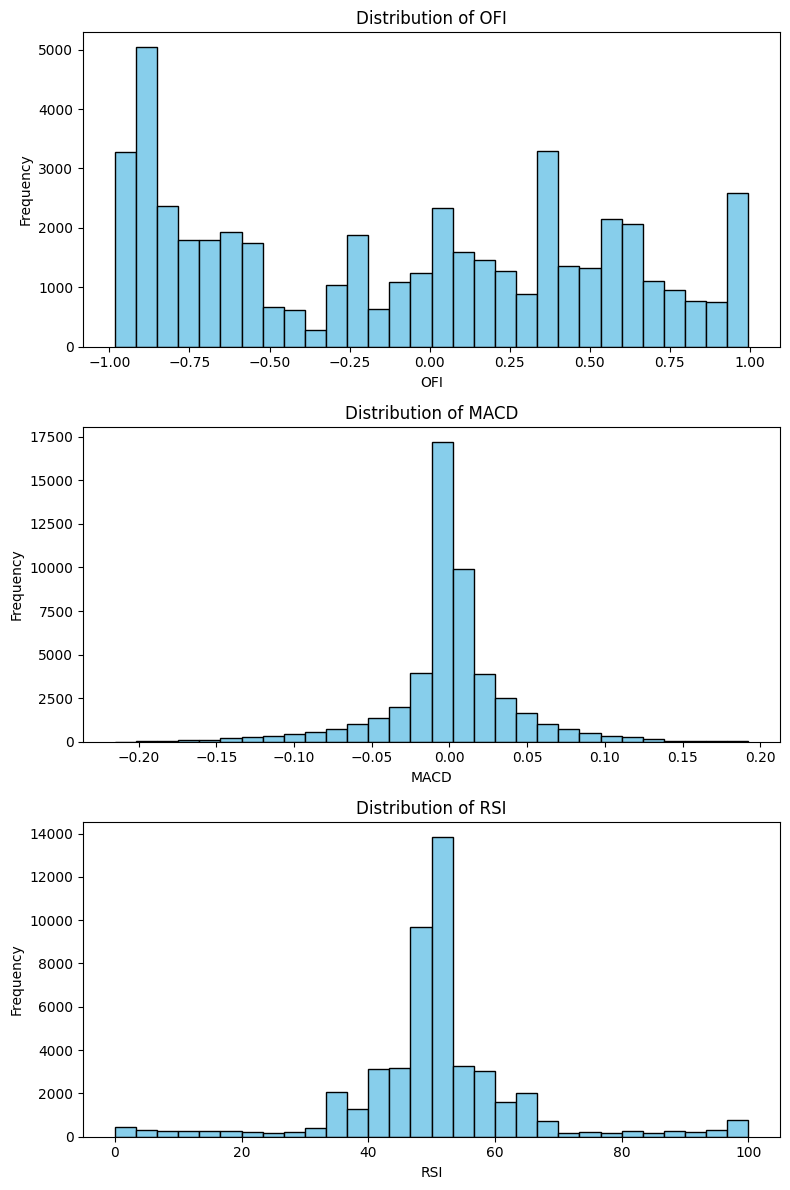

In [105]:
columns = ['OFI', 'MACD', 'RSI']
plot_histograms(filtered_factors, columns)

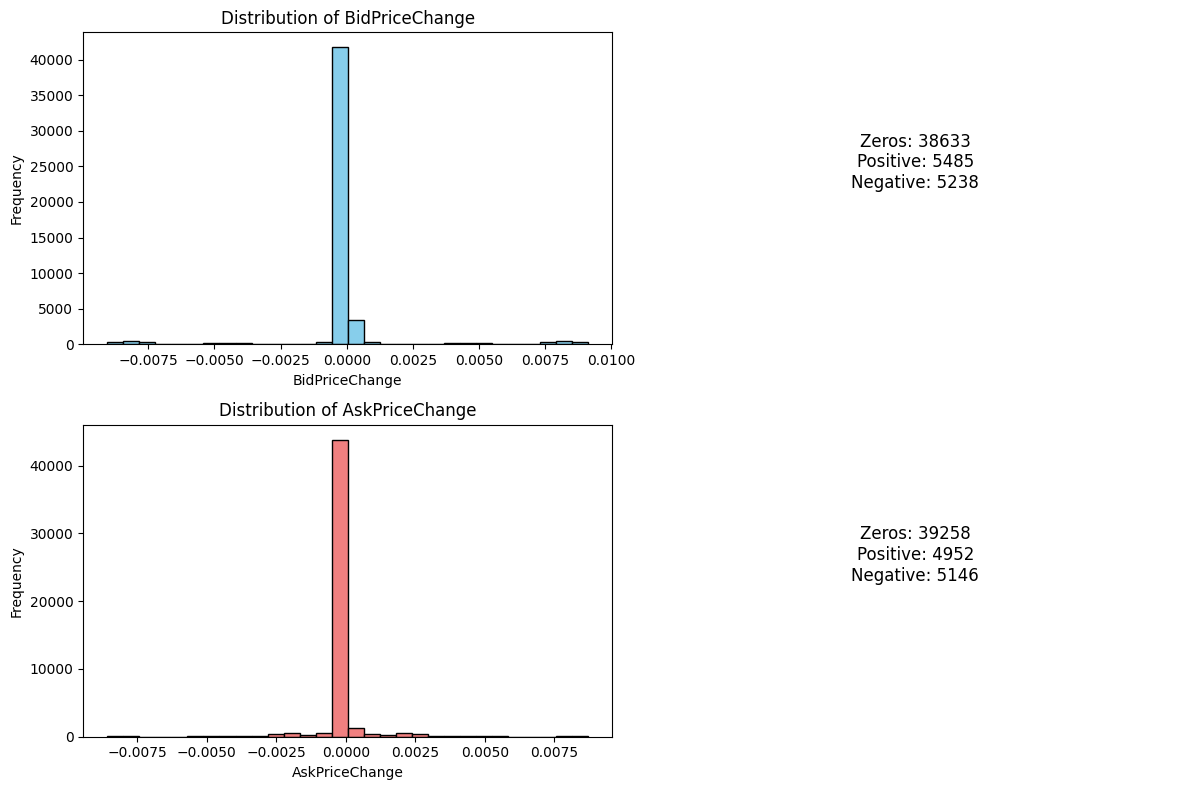

In [106]:
columns = ['BidPriceChange','AskPriceChange']
plot_histograms_and_stats(filtered_factors, columns)


In [132]:
training_start_time, training_end_time = "2021-11-05 18:59:54.93", "2021-11-05 19:45:54.0"
prediction_start_time, prediction_end_time = "2021-11-05 19:45:54.0", "2021-11-05 19:59:54.0"

def get_train_test_windows(df, train_start_time, train_end_time, test_start_time, test_end_time):
    training_window_df = None
    test_window_df = None
    
    try:
        training_start_time = pd.to_datetime(train_start_time)
        training_end_time = pd.to_datetime(train_end_time)
        prediction_start_time = pd.to_datetime(test_start_time)
        prediction_end_time = pd.to_datetime(test_end_time)

        # Check if the desired training window is inside the dataset's time range
        if pd.to_datetime(df['COLLECTION_TIME'].min()) < training_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) > training_end_time:
            training_window_df = filter_time_window(df, training_start_time, training_end_time)
            training_window_df.reset_index(drop=True, inplace=True)

        if pd.to_datetime(df['COLLECTION_TIME'].min()) < prediction_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) > prediction_end_time:
            test_window_df = filter_time_window(df, prediction_start_time, prediction_end_time)
            test_window_df.reset_index(drop=True, inplace=True)

        if len(training_window_df) == 0  or len(test_window_df) == 0:
            print("Desired training or prediction window not inside dataset's time range.")
        else:
            return training_window_df, test_window_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

train_df, test_df = get_train_test_windows(factors, training_start_time, training_end_time, prediction_start_time, prediction_end_time)

feature_cols = ['OFI', 'RSI', 'MACD']
label_cols = ['BID_PRICE_1']


train_features = train_df[feature_cols]
train_labels = train_df[label_cols]
test_features = test_df[feature_cols]
test_labels = test_df[label_cols]

# # Shift labels up by 1 row because we are trying to predict next row's price
# train_labels = train_labels.shift(-1)
# test_labels = test_labels.shift(-1)
# # Remove the last row in training features
# train_features = train_features[:-1]
# train_labels = train_labels[:-1]
# test_features = test_features[:-1]
# test_labels = test_labels[:-1]

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

An error occurred: isinstance() arg 2 must be a type, a tuple of types, or a union


TypeError: 'NoneType' object is not subscriptable

In [108]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(train_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(train_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(test_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(test_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')

X_train contains NaN values: OFI     False
RSI      True
MACD    False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool
X_train contains NaN values: OFI     False
RSI      True
MACD    False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool


In [109]:
# Identify and remove rows with NaN values from both X_train and y_train
nan_indices1 = np.isnan(train_features).any(axis=1)

train_features_c = train_features[~nan_indices1]
train_labels_c = train_labels[~nan_indices1]

nan_indices2 = np.isnan(test_features).any(axis=1)
test_features_c = test_features[~nan_indices2]
test_labels_c= test_labels[~nan_indices2]



In [110]:
train_features = train_features_c
train_labels = train_labels_c

test_features = test_features_c
test_labels = test_labels_c

In [111]:
train_features.head()

OFI        RSI      MACD
0  0.703704  49.888999  0.013898
1  0.744557  50.250352  0.008625
2  0.701188  50.250352  0.004395
3  0.802025  50.250352  0.001031
4  0.701188  50.250352 -0.001616

In [112]:
train_labels.head(6)

BID_PRICE_1
0       150.60
1       150.61
2       150.61
3       150.61
4       150.61
5       150.61

In [113]:
sc_labels = MinMaxScaler(feature_range=(0, 1))

train_labels_scaled = sc_labels.fit_transform(train_labels)

train_labels_scaled[:28]

array([[0.4084507 ],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.28873239]])

In [114]:
test_df.head()

COLLECTION_TIME  BID_PRICE_1  ASK_PRICE_1  BidPriceChange  \
0 2021-11-05 19:45:55.522081024       151.26       151.29             0.0   
1 2021-11-05 19:45:55.524529920       151.26       151.29             0.0   
2 2021-11-05 19:45:55.654966016       151.26       151.29             0.0   
3 2021-11-05 19:45:55.842571008       151.26       151.27             0.0   
4 2021-11-05 19:45:56.096688896       151.26       151.27             0.0   

   AskPriceChange  SpreadChange  BidPriceDir  AskPriceDir       OFI  \
0        0.000000      2.000000            0            1  0.644269   
1        0.000000      0.000000            0            0  0.702970   
2       -0.000132      0.000000            0            0  0.644269   
3        0.000000     -0.666667            0            0  0.590822   
4        0.000000      0.000000            0            0  0.040359   

         RSI      MACD  
0  49.959952  0.003856  
1  49.959952 -0.002231  
2  49.959952 -0.006975  
3  49.959548 -0.011410  
4  49.959548 -0.014755

In [115]:
test_features.head(6)

OFI        RSI      MACD
0  0.644269  49.959952  0.003856
1  0.702970  49.959952 -0.002231
2  0.644269  49.959952 -0.006975
3  0.590822  49.959548 -0.011410
4  0.040359  49.959548 -0.014755
5  0.590822  49.959548 -0.017207

In [116]:
test_labels.head(6)

BID_PRICE_1
0       151.26
1       151.26
2       151.26
3       151.26
4       151.26
5       151.26

In [117]:
# def create_sequences(features, labels, sequence_length):
#     sc = MinMaxScaler(feature_range=(0, 1))
#     # scaler returns numpy array
#     features_np = sc.fit_transform(features)
#     labels_np = sc.fit_transform(labels).reshape(-1, 1)
#     feature_sequences = []
#     label_sequences = []
    
#     for i in range(len(features_np) - sequence_length):
#         feature_sequences.append(features_np[i:i+sequence_length])
#         label_sequences.append(labels_np[i + sequence_length])
    
#     # return feature_sequences, label_sequences
#     return torch.tensor(feature_sequences, dtype=torch.float32), torch.tensor(label_sequences, dtype=torch.float32)

def create_sequences1(features_df, labels_df, sequence_length):
    sc_features = MinMaxScaler(feature_range=(0, 1))
    sc_labels = MinMaxScaler(feature_range=(0, 1))
    
    # Assuming features_df and labels_df are pandas DataFrames
    features_np = sc_features.fit_transform(features_df)
    labels_np = sc_labels.fit_transform(labels_df)

    feature_sequences = []
    label_sequences = []

    for i in range(len(features_df) - sequence_length):
        # Append sequences of length 'sequence_length' to feature_sequences
        feature_sequences.append(features_np[i:i+sequence_length])
        # Append the next label (after the end of the current sequence) to label_sequences
        label_sequences.append(labels_np[i + sequence_length])

    return np.array(feature_sequences), np.array(label_sequences)
    # return torch.tensor(feature_sequences, dtype=torch.float32), torch.tensor(label_sequences, dtype=torch.float32)

sequence_length = 10
X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

# X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
# X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(35400, 10, 3)
(35400, 1)
(13760, 10, 3)
(13760, 1)


In [118]:
X_train[0]

array([[0.85402377, 0.49888999, 0.55678131],
       [0.87470735, 0.50250352, 0.54349255],
       [0.85275034, 0.50250352, 0.53283343],
       [0.90380224, 0.50250352, 0.52435604],
       [0.85275034, 0.50250352, 0.5176846 ],
       [0.8236573 , 0.50250352, 0.51250411],
       [0.68472454, 0.33718598, 0.57690034],
       [0.6870706 , 0.49705082, 0.55938039],
       [0.45285966, 0.49705082, 0.54522518],
       [0.53000281, 0.49705082, 0.53386748]])

In [119]:
y_train[17]

array([0.28873239])

We can verify that the tensors have been formed in proper order by checking the 28th row in the y_label_df and the 17th element in the y_train tensor.

In [120]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [121]:
#!pip install keras
#!pip install tensorflow


In [93]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(10, 3), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)



Epoch 1/30
2124/2124 [==============================] - 11s 5ms/step - loss: 0.0568 - val_loss: 0.1087
Epoch 2/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0551 - val_loss: 0.1125
Epoch 3/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0542 - val_loss: 0.1098
Epoch 4/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0527 - val_loss: 0.1038
Epoch 5/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0501 - val_loss: 0.1026
Epoch 6/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0476 - val_loss: 0.1075
Epoch 7/30
2124/2124 [==============================] - 11s 5ms/step - loss: 0.0455 - val_loss: 0.1139
Epoch 8/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0439 - val_loss: 0.0982
Epoch 9/30
2124/2124 [==============================] - 10s 5ms/step - loss: 0.0429 - val_loss: 0.0982
Epoch 10/30
2124/2124 [==============================] - 10s 5ms/step - l

In [90]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_train).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_train).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_test).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_test).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


X_train contains NaN values: False
y_train contains NaN values: False
X_train contains NaN values: False
y_train contains NaN values: False


In [92]:
import torch
import torch.nn as nn
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # we only want the last time step
        return out

# Initialize constants and the model
input_dim = 3
hidden_dim = 8
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 300
num_predictions_to_print = 5  # Number of predictions to print per epoch

for epoch in range(num_epochs):
    # Convert NumPy arrays to PyTorch tensors
    X_tensor = torch.from_numpy(X_train).float()
    y_tensor = torch.from_numpy(y_train).float()

    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Convert the tensor predictions to a NumPy array
    # and print the first few predictions
    predictions = outputs.detach().numpy()
    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    print(f'First {num_predictions_to_print} Predictions:')
    print(predictions[:num_predictions_to_print])
    print("=" * 50)


# for epoch in range(num_epochs):
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # Convert the tensor predictions to a numpy array
#     # and print the first few predictions
#     predictions = outputs.detach().numpy()
#     print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
#     print(f'First {num_predictions_to_print} Predictions:')
#     print(predictions[:num_predictions_to_print])
#     print("="*50)  # Add a separator for clarity


Epoch 0/300, Loss: 1.0348987579345703
First 5 Predictions:
[[-0.48023045]
 [-0.47429532]
 [-0.45457524]
 [-0.44603008]
 [-0.44408977]]
Epoch 1/300, Loss: 1.0226892232894897
First 5 Predictions:
[[-0.47372678]
 [-0.46789813]
 [-0.4484322 ]
 [-0.4400617 ]
 [-0.43822062]]
Epoch 2/300, Loss: 1.0107039213180542
First 5 Predictions:
[[-0.467305  ]
 [-0.4615817 ]
 [-0.4423683 ]
 [-0.43417016]
 [-0.43242592]]
Epoch 3/300, Loss: 0.9989414215087891
First 5 Predictions:
[[-0.46096617]
 [-0.45534688]
 [-0.43638405]
 [-0.42835587]
 [-0.42670614]]
Epoch 4/300, Loss: 0.9874000549316406
First 5 Predictions:
[[-0.45471093]
 [-0.4491943 ]
 [-0.43047982]
 [-0.42261904]
 [-0.4210613 ]]
Epoch 5/300, Loss: 0.9760775566101074
First 5 Predictions:
[[-0.44853938]
 [-0.443124  ]
 [-0.42465538]
 [-0.4169594 ]
 [-0.41549122]]
Epoch 6/300, Loss: 0.9649706482887268
First 5 Predictions:
[[-0.44245142]
 [-0.43713573]
 [-0.41891038]
 [-0.41137645]
 [-0.40999535]]
Epoch 7/300, Loss: 0.9540758728981018
First 5 Predictio

In [134]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [ ]:
batch_size = 64  # You can adjust the batch size

In [135]:
# For training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# For testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [138]:


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # we only want the last time step
        return out


# Initialize constants and the model
input_dim = 3
hidden_dim = 16
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim,2,0.2)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 30
num_predictions_to_print = 5  # Number of predictions to print per epoch

batch_size = 64  # You can adjust the batch size


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # After each epoch, evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for features, labels in test_loader:
            test_outputs = model(features)
            total_loss += criterion(test_outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item()}, Test Loss: {avg_loss}')

    # Convert the tensor predictions to a NumPy array
    # and print the first few predictions
    predictions = outputs.detach().numpy()
    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    print(f'First {num_predictions_to_print} Predictions:')
    print(predictions[:num_predictions_to_print])
    print("=" * 50)

    
    # After each epoch, you can evaluate on a validation set if you have one


Epoch 0/30, Training Loss: 0.037686027586460114, Test Loss: 0.1441539458497319
Epoch 0/30, Loss: 0.037686027586460114
First 5 Predictions:
[[0.48174345]
 [0.49107593]
 [0.55772835]
 [0.45222598]
 [0.4654128 ]]
Epoch 1/30, Training Loss: 0.10279825329780579, Test Loss: 0.13432788049239058
Epoch 1/30, Loss: 0.10279825329780579
First 5 Predictions:
[[0.5548422 ]
 [0.5443058 ]
 [0.56897616]
 [0.53199345]
 [0.23672971]]
Epoch 2/30, Training Loss: 0.06859909743070602, Test Loss: 0.14397441065588662
Epoch 2/30, Loss: 0.06859909743070602
First 5 Predictions:
[[0.53010327]
 [0.55587816]
 [0.48078263]
 [0.54020613]
 [0.5521047 ]]
Epoch 3/30, Training Loss: 0.02704782411456108, Test Loss: 0.1350175575288229
Epoch 3/30, Loss: 0.02704782411456108
First 5 Predictions:
[[0.5459014 ]
 [0.599374  ]
 [0.6011811 ]
 [0.56085056]
 [0.55082405]]
Epoch 4/30, Training Loss: 0.035995446145534515, Test Loss: 0.12884267672549846
Epoch 4/30, Loss: 0.035995446145534515
First 5 Predictions:
[[0.50569725]
 [0.513162

In [122]:
# import torch
# import torch.nn as nn
# import numpy as np
# import time

# # Define constants
# input_dim = 4  # Change to 4 because of data shape
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

# # Define the LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = self.fc(out[:, -1, :]) 
#         return out

# # Initialize the model, criterion, and optimizer
# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')  # Mean Squared Error Loss
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# # Training loop
# hist = np.zeros(num_epochs)
# start_time = time_module.time()


# for t in range(num_epochs):
#     y_train_pred = model(X_train)
    
#     loss = criterion(y_train_pred, y_train)
#     rmse = torch.sqrt(loss)  # Compute the Root Mean Square Error (RMSE)
    
#     print("Epoch ", t, "MSE: ", loss.item(), "RMSE: ", rmse.item())
    
#     hist[t] = loss.item()
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()
    
# training_time = time_module.time() - start_time
# print("Training time: {}".format(training_time))


TypeError: 'int' object is not callable